In [12]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
import pandas as pd

In [14]:
path = "E:\Data\Omniglot\python\images_background"

In [15]:
def getFiles(path):
    df = pd.DataFrame(columns=['filepath', 'language', 'character' ,'category'])
    for language in os.listdir(path):
        for character in os.listdir("{}\{}".format(path, language)):
            for item in os.listdir("{}\{}\{}".format(path, language, character)):
                df = df.append({'filepath':"{}\{}\{}\{}".format(path, language, character, item), 
                                     'language':language, 
                                     'character': character, 
                                     'category': "{}_{}".format(language,character)}, ignore_index=True)
    return df

In [16]:
df = getFiles(path)

In [17]:
df.head()

,filepath,language,character,category
0,E:\Data\Omniglot\python\images_background\Alph...,Alphabet_of_the_Magi,character01,Alphabet_of_the_Magi_character01
1,E:\Data\Omniglot\python\images_background\Alph...,Alphabet_of_the_Magi,character01,Alphabet_of_the_Magi_character01
2,E:\Data\Omniglot\python\images_background\Alph...,Alphabet_of_the_Magi,character01,Alphabet_of_the_Magi_character01
3,E:\Data\Omniglot\python\images_background\Alph...,Alphabet_of_the_Magi,character01,Alphabet_of_the_Magi_character01
4,E:\Data\Omniglot\python\images_background\Alph...,Alphabet_of_the_Magi,character01,Alphabet_of_the_Magi_character01


In [18]:
df['label'] = df['category'].factorize()[0]


Generates Positive and Negative data based on anchor item

In [126]:
def generateTrainingData(df, n):
    data = []
    for i in range(n):
        anchorItem = df.sample()
        #postive sample
        positiveItem = df[(df['label'] == anchorItem['label'].item()) & (df['filepath'] != anchorItem['filepath'].item())].sample()
        data.append({"anchor":anchorItem.index.item(), "item":positiveItem.index.item(), "label":1.0})
        #negative sample
        negativeItem = df[df['label'] != anchorItem['label'].item()].sample()
        data.append({"anchor":anchorItem.index.item(), "item":negativeItem.index.item(), "label":0.0})
        
    return pd.DataFrame(data)
        
        

In [127]:
data = generateTrainingData(df, 50000)

In [128]:
data.head()

,anchor,item,label
0,2452,2451,1.0
1,2452,5401,0.0
2,11320,11331,1.0
3,11320,3358,0.0
4,14027,14024,1.0


In [129]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, LSTM, Dense, Input, Conv2D, MaxPooling2D, Flatten, Lambda
from tensorflow.keras import backend as K

From Coursera Course

In [153]:
def get_siamese_model(input_shape):
    
    # tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # conv
    model = Sequential()
    model.add(Conv2D(64, (10, 10), 
                     activation='relu', 
                     input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7, 7), 
                     activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4, 4), 
                     activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4, 4), 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(4096, 
                    activation='sigmoid'))
    
    # encodings (feature vectors) for the two images
    left_encoding = model(left_input)
    right_encoding = model(right_input)
    
    # customized layer to compute the absolute difference between the feature vectors
    distance = Lambda(euclidean_distance,
                      output_shape=eucl_dist_output_shape)([left_encoding, right_encoding])

    
    # siamese model connecting the two inputs
    siamese_model = Model(inputs=[left_input, right_input], outputs=distance)
    
    return siamese_model

https://github.com/keras-team/keras/blob/master/examples/mnist_siamese.py

In [154]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [155]:
input_shape = plt.imread(df['filepath'][2]).shape
model = get_siamese_model((105,105,1))
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 4096)         38947648    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1)            0           sequential_3[1][0]         

In [156]:
model.compile(loss=contrastive_loss, 
              optimizer='adam', metrics=[accuracy])

In [157]:
class Omniglot(tf.keras.utils.Sequence):

    def __init__(self, df, data, batch_size):
        self.df = df
        self.data = data
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_df = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        anchor = batch_df['anchor'].values
        anchor_data = np.array([plt.imread(self.df.iloc[index].filepath) for index in anchor])
        item = batch_df['item'].values
        item_data = np.array([plt.imread(self.df.iloc[index].filepath) for index in item])
        batch_y = batch_df['label'].values
        
        anchor_data = anchor_data.reshape((anchor_data.shape[0],105,105,1))
        item_data = item_data.reshape((item_data.shape[0],105,105,1))
        
        return [anchor_data, item_data], batch_y

In [158]:
generator = Omniglot(df, data, 32)

In [160]:
model.fit_generator(generator, epochs=100)

Epoch 1/100
603/603 [==============================] - 37s 61ms/step - loss: 0.1601 - accuracy: 0.7706
Epoch 2/100
603/603 [==============================] - 37s 62ms/step - loss: 0.1542 - accuracy: 0.7836
Epoch 3/100
603/603 [==============================] - 37s 61ms/step - loss: 0.1498 - accuracy: 0.7907
Epoch 4/100
603/603 [==============================] - 37s 62ms/step - loss: 0.1485 - accuracy: 0.7918
Epoch 5/100
603/603 [==============================] - 37s 62ms/step - loss: 0.1473 - accuracy: 0.7947
Epoch 6/100
603/603 [==============================] - 38s 63ms/step - loss: 0.1466 - accuracy: 0.7961
Epoch 7/100
603/603 [==============================] - 39s 65ms/step - loss: 0.1457 - accuracy: 0.7990
Epoch 8/100
603/603 [==============================] - 40s 66ms/step - loss: 0.1439 - accuracy: 0.8022
Epoch 9/100
603/603 [==============================] - 40s 67ms/step - loss: 0.1422 - accuracy: 0.8063
Epoch 10/100
603/603 [==============================] - 40s 67ms/step - l

603/603 [==============================] - 38s 63ms/step - loss: 0.0799 - accuracy: 0.9125
Epoch 80/100
603/603 [==============================] - 38s 63ms/step - loss: 0.0798 - accuracy: 0.91250s - loss: 0
Epoch 81/100
603/603 [==============================] - 37s 62ms/step - loss: 0.0789 - accuracy: 0.9146
Epoch 82/100
603/603 [==============================] - 37s 61ms/step - loss: 0.0794 - accuracy: 0.9139
Epoch 83/100
603/603 [==============================] - 37s 61ms/step - loss: 0.0787 - accuracy: 0.9154
Epoch 84/100
603/603 [==============================] - 37s 61ms/step - loss: 0.0801 - accuracy: 0.9134
Epoch 85/100
603/603 [==============================] - 37s 61ms/step - loss: 0.0785 - accuracy: 0.9132
Epoch 86/100
603/603 [==============================] - 37s 61ms/step - loss: 0.0782 - accuracy: 0.9144
Epoch 87/100
603/603 [==============================] - 37s 61ms/step - loss: 0.0775 - accuracy: 0.9142
Epoch 88/100
603/603 [==============================] - 37s 61ms/

In [161]:
model.save_weights("omniglot.h5")

In [162]:
def getRandom(data, df):
    a = data.sample()
    return plt.imread(df.iloc[a.anchor.item()].filepath).reshape(1,105,105,1), plt.imread(df.iloc[a.item.item()].filepath).reshape(1,105,105,1), a.label.item()

In [220]:
def predictRandom(data,df, model, threshold):
    a = data.sample()
    item = plt.imread(df.iloc[a.anchor.item()].filepath).reshape(1,105,105,1)
    item2 = plt.imread(df.iloc[a.item.item()].filepath).reshape(1,105,105,1)
    label = a.label.item()
    f, axarr = plt.subplots(2)

    axarr[0].imshow(plt.imread(df.iloc[a.anchor.item()].filepath))
    axarr[1].imshow(plt.imread(df.iloc[a.item.item()].filepath))
    
    if(label == 1):
        print("Same")
    else:
        print("Different")
              
    prediction = model.predict([item,item2]).item()
    print("Pred: {}".format(prediction))
    if(prediction < threshold):
        print("Predicted to be same items")
    else:
        print("Predicted to be different items")

Same
Pred: 0.6791574358940125
Predicted to be same items


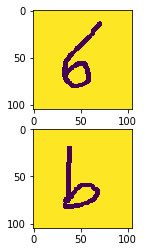

In [262]:
predictRandom(data,df, model, 1)